# <center> Swap design using Constraint Programming </center>

In [6]:
!pip install -q ortools networkx numpy pandas

In [1]:
import os
import numpy as np 
import pandas as pd
import networkx as nx
from ortools.sat.python import cp_model

## Interest Rate Swap (IRS) on Loans

Companies A and B have been offered the following rates per annum on a $20 million
5-year loan:

||Fixed Rate|Floating Rate|
|-|----|--------|
|Company A|5%|SOFR+0.1%|
|Company B|6.4%|SOFR+0.6%|

Company A requires a floating-rate loan; company B requires a fixed-rate loan. Design a
swap that will net a bank, acting as intermediary, 0.1% per annum and that will appear
equally attractive to both companies.

- Bank gain: 0.1%
- A: floating rate loan
- B: fixed rate loan

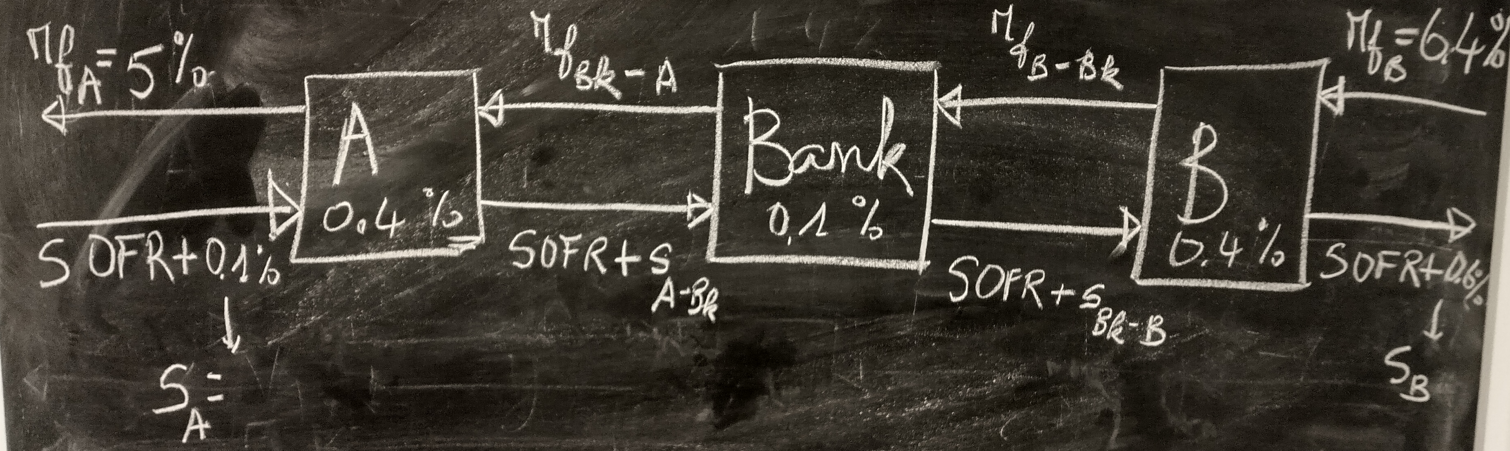

Possible solution:

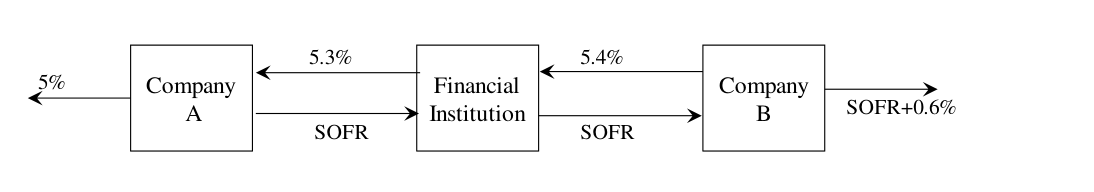

Let be:

- Known parameters:

    - $r_{f_{A}}$: the fixed interest rate of a loan for Company A;
    - $s_{A}$: the spread of credit in floating rate for company A;
    - $s_B$: the spread of credit in floating rate for company B;
    - $G_{bank}$: Bank profit
    - $G_A$: Company A profit
    - $G_B$: Company B profit

- Variables:

    + $r_{f_{Bk-A}}$: the fixed interest rate the bank agrees to pay to company A;
    + $s_{A-Bk}$ the spread of credit company A gives to the bank on floating rate;
    + $r_{f_{B-Bk}}$: the fixed interest rate company B pays to the bank;
    + $s_{Bk-B}$: the spread of credit the bank pays to company B on floating rate;



Let's define a constraint satisfiability problem:


\begin{cases}
(r_{f_{B}}-r_{f_{B-Bk}})+(S_{Bk-B}-s_{B}) = G_B\\
(r_{f_{Bk-A}}-r_{f_{A}})+(s_{A} - s_{A-Bk}) = G_A\\
(r_{f_{B-Bk}}-r_{f_{Bk-A}})+(s_{A-Bk}-s_{Bk-B}) = G_{Bank}\\
r_{f_{Bk-A}} \leq r_{f_{B-Bk}}\\
s_{Bk-B} \leq s_{A-Bk}\\
r_{f_{Bk-A}} \geq r_{f_{A}}\\
r_{f_{B-Bk}} \leq r_{f_{B}}\\
s_{A} \geq s_{A-Bk}\\
s_{Bk-B} \leq s_B
\end{cases}

On 10 scale basis:

\begin{cases}
10(r_{f_{B}}-s_{B})+(S_{Bk-B}-r_{f_{B-Bk}}) = 10 G_B\\
(r_{f_{Bk-A}}- s_{A-Bk})+10(s_{A} -r_{f_{A}}) = 10G_A\\
(r_{f_{B-Bk}}-r_{f_{Bk-A}})+(s_{A-Bk}-s_{Bk-B}) = 10G_{Bank}\\
r_{f_{Bk-A}} \leq r_{f_{B-Bk}}\\
s_{Bk-B} \leq s_{A-Bk}\\
r_{f_{Bk-A}} \geq 10r_{f_{A}}\\
r_{f_{B-Bk}} \leq 10r_{f_{B}}\\
10s_{A} \geq s_{A-Bk}\\
s_{Bk-B} \leq 10s_B
\end{cases}

In [2]:
class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, variables, max_dec_digits):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.max_dec_digits = max_dec_digits
        self.__solution_count = 0
        self.solutions = []
        
        
    def on_solution_callback(self):
        self.__solution_count += 1
        for v in self.__variables:
            print(f"{v}={self.Value(v)/self.max_dec_digits:.2f}", end=" ")
        print()
        self.solutions.append({v.Name(): self.Value(v)/self.max_dec_digits for v in self.__variables})

    @property
    def solution_count(self):
        return self.__solution_count


def search_for_all_solutions_sample_sat( rf_A, rf_B, s_A, s_B, G_B, G_A, G_bank):
    """Showcases calling the solver to search for all solutions."""
    # Creates the model.
    model = cp_model.CpModel()
    max_dec_digits = 10**max([len(x) for x in [str(rate).split(".")[-1] for rate in [rf_A, rf_B, s_A, s_B]]])
    
    rates_upper_bound = int(max_dec_digits*max(rf_A, rf_B))
    # Define the variables
    r_f_B_Bk = model.NewIntVar(0, rates_upper_bound, 'r_f_B_Bk')  # Upper bound 64.0
    s_Bk_B = model.NewIntVar(-int(max_dec_digits*s_B), int(max_dec_digits*s_B), 's_Bk_B')       # Upper bound 6.0
    r_f_Bk_A = model.NewIntVar(0, rates_upper_bound, 'r_f_Bk_A')  # Upper bound 64.0
    s_A_Bk = model.NewIntVar(-int(max_dec_digits*s_A), int(max_dec_digits*s_A), 's_A_Bk')       # Upper bound 1.0

    # Define the constraints
    model.Add(int(max_dec_digits*(rf_B-s_B)) - r_f_B_Bk + s_Bk_B == int(max_dec_digits*G_B))  # 58 - r_f_B_Bk + s_Bk_B == 4
    model.Add(r_f_Bk_A - s_A_Bk + int(max_dec_digits*(s_A-rf_A))== int(max_dec_digits*G_A))  # r_f_Bk_A - 49 - s_A_Bk == 4
    model.Add(r_f_B_Bk - r_f_Bk_A + s_A_Bk - s_Bk_B == int(max_dec_digits*G_bank))  # r_f_B_Bk - r_f_Bk_A + s_A_Bk - s_Bk_B == 1
    # model.Add(r_f_Bk_A <= r_f_B_Bk)
    # model.Add(s_Bk_B <= s_A_Bk)
    model.Add(r_f_Bk_A >= int(max_dec_digits*rf_A))
    model.Add(r_f_B_Bk <= int(max_dec_digits*rf_B))
    model.Add(s_A_Bk <= int(max_dec_digits*s_A))
    model.Add(s_Bk_B <= int(max_dec_digits*s_B))

    # Create a solver and solve.
    solver = cp_model.CpSolver()
    solution_printer = VarArraySolutionPrinter([r_f_B_Bk, s_Bk_B, r_f_Bk_A, s_A_Bk], max_dec_digits)
    # Enumerate all solutions.
    solver.parameters.enumerate_all_solutions = True
    # Solve.
    status = solver.Solve(model, solution_printer)

    print(f"Status = {solver.StatusName(status)}")
    print(f"Number of solutions found: {solution_printer.solution_count}")
    return solution_printer.solutions


solutions = search_for_all_solutions_sample_sat(5, 6.4, 0.1, 0.6, 0.4, 0.4, 0.1)

r_f_B_Bk=4.80 s_Bk_B=-0.60 r_f_Bk_A=5.20 s_A_Bk=-0.10 
r_f_B_Bk=4.80 s_Bk_B=-0.60 r_f_Bk_A=5.30 s_A_Bk=0.00 
r_f_B_Bk=4.80 s_Bk_B=-0.60 r_f_Bk_A=5.40 s_A_Bk=0.10 
r_f_B_Bk=4.90 s_Bk_B=-0.50 r_f_Bk_A=5.40 s_A_Bk=0.10 
r_f_B_Bk=4.90 s_Bk_B=-0.50 r_f_Bk_A=5.30 s_A_Bk=0.00 
r_f_B_Bk=5.00 s_Bk_B=-0.40 r_f_Bk_A=5.30 s_A_Bk=0.00 
r_f_B_Bk=5.00 s_Bk_B=-0.40 r_f_Bk_A=5.40 s_A_Bk=0.10 
r_f_B_Bk=5.10 s_Bk_B=-0.30 r_f_Bk_A=5.40 s_A_Bk=0.10 
r_f_B_Bk=5.10 s_Bk_B=-0.30 r_f_Bk_A=5.30 s_A_Bk=0.00 
r_f_B_Bk=5.20 s_Bk_B=-0.20 r_f_Bk_A=5.30 s_A_Bk=0.00 
r_f_B_Bk=5.20 s_Bk_B=-0.20 r_f_Bk_A=5.40 s_A_Bk=0.10 
r_f_B_Bk=5.30 s_Bk_B=-0.10 r_f_Bk_A=5.40 s_A_Bk=0.10 
r_f_B_Bk=5.30 s_Bk_B=-0.10 r_f_Bk_A=5.30 s_A_Bk=0.00 
r_f_B_Bk=5.40 s_Bk_B=0.00 r_f_Bk_A=5.30 s_A_Bk=0.00 
r_f_B_Bk=5.40 s_Bk_B=0.00 r_f_Bk_A=5.40 s_A_Bk=0.10 
r_f_B_Bk=5.50 s_Bk_B=0.10 r_f_Bk_A=5.40 s_A_Bk=0.10 
r_f_B_Bk=5.50 s_Bk_B=0.10 r_f_Bk_A=5.30 s_A_Bk=0.00 
r_f_B_Bk=5.60 s_Bk_B=0.20 r_f_Bk_A=5.30 s_A_Bk=0.00 
r_f_B_Bk=5.60 s_Bk_B=0.20 r_f_Bk

In [3]:
pd.DataFrame(solutions)

,r_f_B_Bk,s_Bk_B,r_f_Bk_A,s_A_Bk
0,4.8,-0.6,5.2,-0.1
1,4.8,-0.6,5.3,0.0
2,4.8,-0.6,5.4,0.1
3,4.9,-0.5,5.4,0.1
4,4.9,-0.5,5.3,0.0
5,5.0,-0.4,5.3,0.0
6,5.0,-0.4,5.4,0.1
7,5.1,-0.3,5.4,0.1
8,5.1,-0.3,5.3,0.0
9,5.2,-0.2,5.3,0.0


In [4]:
search_for_all_solutions_sample_sat(8, 8.8, 0.0, 0.0, 0.3, 0.3, 0.2)

r_f_B_Bk=8.50 s_Bk_B=0.00 r_f_Bk_A=8.30 s_A_Bk=0.00 
Status = OPTIMAL
Number of solutions found: 1


[{'r_f_B_Bk': 8.5, 's_Bk_B': 0.0, 'r_f_Bk_A': 8.3, 's_A_Bk': 0.0}]

## Interest Rate Swap (IRS) on Investments

In [5]:
def search_for_all_solutions_sample_sat(rfDollar_A, rfDollar_B, rfYen_A, rfYen_B, G_B, G_A, G_bank):
    """Showcases calling the solver to search for all solutions."""
    model = cp_model.CpModel()

    # Calculate max_dec_digits carefully based on decimal places of the rates
    max_dec_digits = 10**max([len(str(rate).split(".")[-1]) for rate in [rfDollar_A, rfDollar_B, rfYen_A, rfYen_B]])
    print(f"max_dec_digits: {max_dec_digits}")
    
    rates_upper_bound = int(max_dec_digits)

    # Define the variables
    r_f_Dollar_A_Bk = model.NewIntVar(0, rates_upper_bound, 'r_f_Dollar_A_Bk')
    r_f_Yen_Bk_A = model.NewIntVar(0, rates_upper_bound, 'r_f_Yen_Bk_A')  
    r_f_Dollar_Bk_B = model.NewIntVar(0, rates_upper_bound, 'r_f_Dollar_Bk_B')
    r_f_Yen_B_Bk = model.NewIntVar(0, rates_upper_bound, 'r_f_Yen_B_Bk') 

    # Define constraints
    model.Add(int(max_dec_digits * rfDollar_B) - r_f_Dollar_Bk_B - r_f_Yen_B_Bk + int(max_dec_digits * rfYen_B) == int(max_dec_digits * G_B))  
    model.Add(int(max_dec_digits * rfDollar_A) - r_f_Dollar_A_Bk - int(max_dec_digits * rfYen_A) + r_f_Yen_Bk_A == int(max_dec_digits * G_A))  
    model.Add(r_f_Dollar_Bk_B - r_f_Dollar_A_Bk + r_f_Yen_B_Bk - r_f_Yen_Bk_A == int(max_dec_digits * G_bank))

    # Check if variables and constraints are consistent
    print(f"Constraints are set. Variables: {r_f_Dollar_A_Bk}, {r_f_Yen_Bk_A}, {r_f_Dollar_Bk_B}, {r_f_Yen_B_Bk}")

    # Create a solver and solve
    solver = cp_model.CpSolver()
    solution_printer = VarArraySolutionPrinter([r_f_Dollar_A_Bk, r_f_Yen_Bk_A, r_f_Dollar_Bk_B, r_f_Yen_B_Bk], max_dec_digits)
    
    # Enable all solution enumeration
    solver.parameters.enumerate_all_solutions = True
    status = solver.Solve(model, solution_printer)

    print(f"Status = {solver.StatusName(status)}")
    print(f"Number of solutions found: {solution_printer.solution_count}")
    return solution_printer.solutions

solutions = search_for_all_solutions_sample_sat(9.6, 10, 5, 6.5, 0.3, 0.3, 0.5)
pd.DataFrame(solutions).to_csv("solutions.csv", index=False)
pd.DataFrame(solutions)

max_dec_digits: 100
Constraints are set. Variables: r_f_Dollar_A_Bk, r_f_Yen_Bk_A, r_f_Dollar_Bk_B, r_f_Yen_B_Bk
Status = INFEASIBLE
Number of solutions found: 0


""
